# Machine Learning - Practical 2 - Linear Regression with Pytorch

Names: {Lars Kaesberg, Luca Francis, Matthias Mildenberger}
Summer Term 2023   
Due Date: Tuesday, May 16, 2pm

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Machine learning 1` -> `Files` -> `Submission of Homework 2`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

## How to work on the exercise?

You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are some initial steps to work with Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Noteboook` -> `Browse and  Import`.

# Introduction

In this task you will get to know the basic tools used by the machine learning community.
Later, we will build a logistic regression model with PyTorch and perform training and prediction the linear regression problem from the previous practical.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [PyTorch Tutorial](https://pytorch.org/tutorials/)
*   [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html)


## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [1]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from sklearn.model_selection import train_test_split

In [2]:
torch.set_default_dtype(torch.float64)

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the top-right corner menu `|<` -> `Settings` -> `Accelerator` -> Select `GPU` as Hardware accelerator.

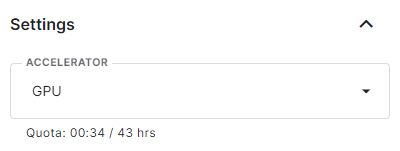

Now check the availability again (after re-running the imports)

In [4]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

Choose your device for computation. CPU or one of your CUDA devices?

In [5]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


# PyTorch: Getting to know Tensors

PyTorch is a library for deep learning on arbitray datasets, including irregular input data such as graphs, point clouds and manifolds. 

In this short tutorial we will explore some of its features to handle data in tensors. 
If you want, you can look into more [detailed PyTorch tutorials](https://pytorch.org/tutorials/) online.

In [6]:
# create a numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [7]:
# TODO print the tensor
a

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], dtype=torch.int32)

In [8]:
# TODO print its type
type(a)

torch.Tensor

In [9]:
# TODO print its shape
a.shape

torch.Size([2, 5])

In [10]:
# TODO print its size
a.size()

torch.Size([2, 5])

In [11]:
# TODO create a new numpy array out of the tensor and print its size
a_numpy = a.numpy()
a_numpy.size

10

Let's create some new tensors.

In [12]:
# TODO create a tensor of shape (2,5) filled with ones of type int and print it
torch.ones((2,5), dtype=int)

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])

In [13]:
# TODO create a tensor of shape (3,4) filled with zeros and print it
torch.zeros((3,4))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [14]:
# TODO transpose the tensor 'a'
a.T

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]], dtype=torch.int32)

Now change a value in the numpy array. Does the corresponding tensor change?

In [15]:
# TODO change value in numpy array and inspect the tensor a
a_numpy[0][0] = 10
a

tensor([[10,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]], dtype=torch.int32)

In [16]:
a[0][0] = 0
a_numpy

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

**TODO Your answer here** - 

Yes the corresponding tensor changes.

Does it work the other way round as well?

**TODO Your answer here** -

Yes that works too.

Now we want to make use of the different devices available, namely cpu and gpu. 

In [17]:
# TODO move 'a' to the gpu
a_gpu = a.to(device)
a_gpu

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0', dtype=torch.int32)

In [18]:
a[0][0] = 10
a_gpu

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0', dtype=torch.int32)

If you change a value in the tensor 'a' now, does the corresponding value in the tensor on the GPU change as well?

**TODO Your answer here** -

No that does not work.

# Deep Learning with Pytorch

The process of training and evaluating a deep learning model begins with **data loading**.
A dataset needs to be chosen on which the model should be trained.
This data might need some preprocessing (like resizing or normalizing) of images. As Pytorch does not have in-build preprocessing for data pannels we have to define our custom normalisation inside a Dataset or Dataloader.
Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function.
An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The **model fitting** is split into training and evaluation.
In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction.
The loss compares the prediction with the ground truth.
In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step.
In the evaluation process the loss is computed on the entire validation set.
This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting.
The model fitting process is repeated for `N` epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.


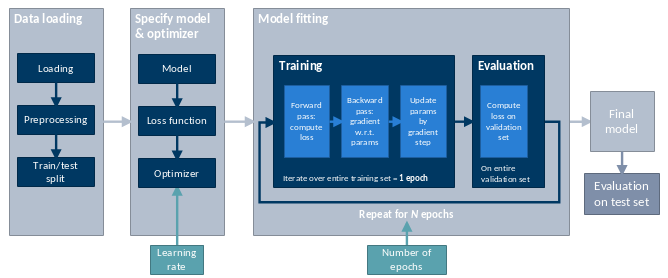

## Data Loading and Preprocessing 

### Training, Validation and Test Sets

For the correct fitting of a neural network model we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data. 

Note that you should not use the test set in any part of your training and model selection procedure. It should be only used for showing the final results.  

Usually, train and test datasets are already splitted in the provided kaggle datasets but as we work with a custom dataset, we would have to make train-test split ourselves first.

In [19]:
test_size = 0.2
target_clm='critical_temp'

In [20]:
# TODO: load data - same as in the previous practical and make train_test_split from sklearn
data = pd.read_csv('data/superconduct_train.csv')
train, test = train_test_split(data, test_size=test_size)

### Dataset

PyTorch has 2 entities to load data. They are **Dataset** and **Dataloader**. 
**Dataset** is a class, which defines your data and often applies data preprocessing transformations, like normalisation. It should have at least 3 functions :
* __init__ - as any other init. Usually, you would provide path to dataset here or dataset elements.
* __len__ - should return the whole dataset size
* __getitem__ - this function returns 1 pair of data and label, also here preprocessing transformations are usually applied



For the next exercise, take a look here for an example https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, target_clm, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = torch.tensor(df.loc[:, df.columns!=target_clm].values)
        self.y = torch.tensor(df[[target_clm]].values)
        self.mean = mean
        self.std = std
        self.normalise = normalise

    def __len__(self):
        return len(self.y)


    def __getitem__(self, index):
        data = self.x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.y[index]

In [22]:
tmp_dataset = Dataset(train, target_clm, normalise=False)

In [23]:
# TODO calculate the mean and standard deviation of train dataset
mean = tmp_dataset.x.mean(dim = 0)
std = tmp_dataset.x.std(dim = 0)

mean, std

(tensor([4.1138e+00, 8.7515e+01, 7.2953e+01, 7.1248e+01, 5.8526e+01, 1.1656e+00,
         1.0639e+00, 1.1555e+02, 3.3206e+01, 4.4394e+01, 4.1426e+01, 7.6993e+02,
         8.7042e+02, 7.3771e+02, 8.3276e+02, 1.2991e+00, 9.2714e-01, 5.7278e+02,
         4.8339e+02, 2.1597e+02, 2.2408e+02, 1.5795e+02, 1.3471e+02, 1.4440e+02,
         1.2099e+02, 1.2677e+00, 1.1307e+00, 1.3931e+02, 5.1397e+01, 5.1605e+01,
         5.2311e+01, 6.1092e+03, 5.2665e+03, 3.4558e+03, 3.1151e+03, 1.0718e+00,
         8.5529e-01, 8.6755e+03, 2.9102e+03, 3.4194e+03, 3.3197e+03, 7.6905e+01,
         9.2709e+01, 5.4430e+01, 7.2458e+01, 1.0703e+00, 7.7115e-01, 1.2074e+02,
         5.9287e+01, 4.8903e+01, 4.4368e+01, 1.4312e+01, 1.3886e+01, 1.0136e+01,
         1.0163e+01, 1.0922e+00, 9.1220e-01, 2.1185e+01, 8.2721e+00, 8.3494e+00,
         7.7370e+00, 8.9608e+01, 8.1666e+01, 2.9864e+01, 2.7405e+01, 7.2772e-01,
         5.3928e-01, 2.5041e+02, 6.2222e+01, 9.8780e+01, 9.6129e+01, 3.1989e+00,
         3.1524e+00, 3.0566e

In [24]:
# TODO define new datasets with mean, std and normalise=True
conductor_train = Dataset(train,target_clm,mean,std,True)
conductor_test = Dataset(test,target_clm,mean,std,True)

We need to **split** the train dataset in two sets, one for training and one for validation. 
While the training set needs to be quite large, the validation set can be relatively small.
Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure reproducibility.

In [25]:
# split the train dataset in conductor_train and conductor_val
conductor_train, conductor_val = torch.utils.data.random_split(conductor_train, [int(0.9 * len(conductor_train)), int(0.1 * len(conductor_train))], generator=torch.Generator().manual_seed(42))

In [26]:
batch_size = 256

To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.
**Dataloader** calls \_\_getitem__ function from the Dataset and forms the batches.


Use the batch size as specified above.
Make sure we get shuffled samples in batches.

In [27]:
# TODO create dataloader for training, validation and test
train_dataloader = torch.utils.data.DataLoader(conductor_train, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(conductor_val, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(conductor_test, 1, shuffle=True)

Let's get a data point now to see what we're dealing with. 

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [28]:
# TODO display an element of the train_dataloader
element = next(iter(train_dataloader))
element

[tensor([[-0.0792, -0.3400, -0.1815,  ...,  0.8713,  0.5115,  1.2502],
         [-0.0792, -1.1585, -0.6468,  ...,  0.1198,  1.3151,  2.1168],
         [ 1.3120,  0.5529, -0.5770,  ..., -0.5198,  0.7667,  0.4216],
         ...,
         [ 0.6164,  0.5414, -0.4315,  ..., -0.3563,  0.1084,  0.4957],
         [ 0.6164, -0.8824, -0.7557,  ..., -0.5666, -0.4323, -0.6531],
         [-1.4704,  0.3512,  0.9514,  ..., -0.0846,  0.3263,  0.7073]]),
 tensor([[2.1800e+01],
         [1.7000e+01],
         [1.0530e+02],
         [3.9300e+01],
         [2.5000e+01],
         [2.2700e+00],
         [1.0600e+01],
         [5.9800e+00],
         [3.5600e+00],
         [3.0700e+00],
         [7.4000e+01],
         [6.9000e+00],
         [9.1075e+01],
         [9.2000e+00],
         [8.1500e+01],
         [2.2000e+01],
         [1.3000e+01],
         [9.2400e+01],
         [2.0900e+01],
         [7.2200e+01],
         [2.7200e+00],
         [1.2100e+00],
         [8.9000e+00],
         [8.9000e+01],
      

In [29]:
# TODO display the dimensions of x and y
element[0].shape, element[1].shape

(torch.Size([256, 81]), torch.Size([256, 1]))

x has size (\[batchsize\], 81) --> 256 elements/batches (or whatever you have defined in your data loader), 81 feature values.

y has size (\[batchsize\], 1) --> 256 elements/batches (again depends on your data loader config). There's one target value for each set of the features.

## Specify Model & Optimizer

### Specify a Model

The task is now to define a model to train on the data. In this simple example, we only need **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training input row.

Before, we set some variables: 
- the input and output size of the linear layer
- how long we want to train the model (number of epochs) and 
- the learning rate.


In [30]:
epochs = 15
input_dim = 81
output_dim = 1
lr = 0.001

In [31]:
class LinearRegression(torch.nn.Module):
    """
    Logistic regression model inherits the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LinearRegression, self).__init__()
        self.layer = torch.nn.Linear(input_dim,output_dim)


    def forward(self, x: torch.Tensor):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # 81
        # TODO flatten the input to a suitable size for the initial layer
        # TODO run the data through the layer
        outputs = self.layer(x)

        return outputs

### Instantiate the Model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [32]:
# TODO instantiate the model
model = LinearRegression(input_dim, output_dim)

Feed the model to the GPU if available.

In [33]:
# TODO move model to device you specified above
model = model.to(device)

Put the model in training mode.

In [34]:
# TODO put the model in train mode
model.train()

LinearRegression(
  (layer): Linear(in_features=81, out_features=1, bias=True)
)

### Define a Loss Function

Since we're dealing with regression progrem, [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) is the canonical choice for the loss. 

In [35]:
# TODO define the loss function
loss_function = torch.nn.MSELoss()

### Define the Optimizer

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).

In [36]:
# DO NOT CHANGE!
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Model Fitting

### Train the Model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the elements of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

In [37]:
model = model.to(device)
from tqdm import tqdm
# TODO fill in the missing lines
progress_bar = tqdm(range(epochs))
for epoch in progress_bar:
    for i, (x, y) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        optimizer.zero_grad()

        # Forward pass: get predictions
        y_pred = model(x.to(device))

        # Compute loss
        loss = loss_function(y_pred.cpu(), y)

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
    progress_bar.set_description(f"{loss.item()}")
        

456.8668818032525: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s] 


### Make a Prediction

Now that our model is trained, we can make a new prediction by inputting an unseen data row from the test dataset.

Run this cell several times, does the model predict accurately?

Set the number of epochs to 15 and try again!

**TODO your answer here** -
With only one epoch it performs not very good but the accuracy increases with the number of epochs

In [38]:
# TODO get a random element of the test dataloader
x, y = next(iter(test_dataloader))
# TODO set model in eval mode
model = model.cpu()
model.eval()
# no automatic gradient update needed in evaluation
with torch.no_grad():
    # TODO make a prediction
    y_pred = model(x)

# print predicted label and given label
print("predicted label: ", y_pred)
print("given label: ", y)

predicted label:  tensor([[0.5383]])
given label:  tensor([[7.2000]])


### Track and Plot the Training and Validation error 

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interesting to see more about the training process, for instance how the training error evolves with time.

For this step, we are going to **refine the training process** and **add some important information saving for plotting**.

Create a plot using **seaborn** that contains both the losses on training set and the losses on the validation set for each epoch.


The plot should look similar to this:


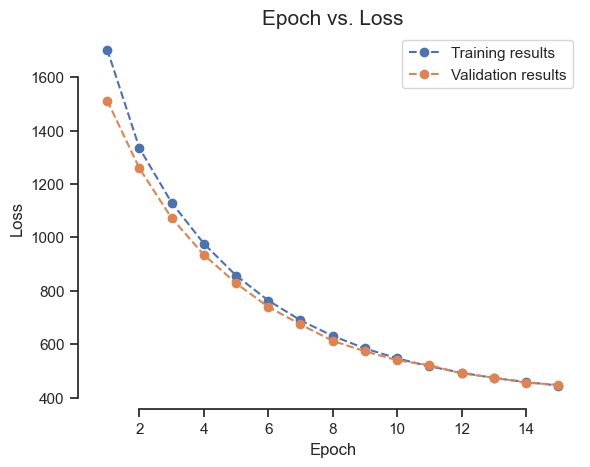


**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind for future exercise sheets.

In [39]:
# TODO refine the training function from above
# it should contain:
# - saving of losses
# - returning the mean loss


def train_epoch(model, dataloader) -> (float, list):
    model = model.to(device)
    losses_batch = []
    for i, (x, y) in enumerate(dataloader):
        # delete the gradients from last training iteration
        optimizer.zero_grad()
        # Forward pass: get predictions
        y_pred = model(x.to(device))
        # Compute loss
        loss = loss_function(y_pred.cpu(), y)
        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        losses_batch.append(loss.item())
    return np.mean(losses_batch) 
    


In [40]:
# TODO write a validation function that calculates the loss on the validation set
# you can also combine it with the training function
def validate(model, val_dataloader):
    with torch.no_grad():
        model = model.to(device)
        losses_batch = []
        for i, (x, y) in enumerate(val_dataloader):
            y_pred = model(x.to(device))
            loss = loss_function(y_pred.cpu(), y)
            losses_batch.append(loss.item())
            
        return np.mean(losses_batch)

In [41]:
# TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses as arrays for each epoch

def run_training(num_epochs, model, optimizer, loss_function, train_dataloader, val_dataloader):
    progress_bar = tqdm(range(num_epochs))
    train_losses = []
    val_losses = []
    for epoch in progress_bar:
        train_loss = train_epoch(model, train_dataloader)
        val_loss = validate(model, val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        progress_bar.set_description(f"Epoch {epoch+1}. Train loss: {train_loss}. Val loss: {val_loss}")
    return (train_losses, val_losses)
        


In [42]:
# TODO call the run_training function and run it for 10 epochs.
num_epochs = 15
model = LinearRegression(input_dim, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_function = torch.nn.MSELoss()

train_losses, val_losses = run_training(num_epochs, model, optimizer, loss_function, train_dataloader, val_dataloader)

Epoch 15. Train loss: 448.3552362341388. Val loss: 430.9677160897539: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]  


In [43]:
# TODO write a plot function with seaborn. 
sns.set_theme()

def plot_losses(train_losses, val_losses):
    sns.lineplot(x=range(len(train_losses)), y=train_losses, label='train', marker="o",linestyle='dashed')
    sns.lineplot(x=range(len(val_losses)), y=val_losses, label='val', marker="o",linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

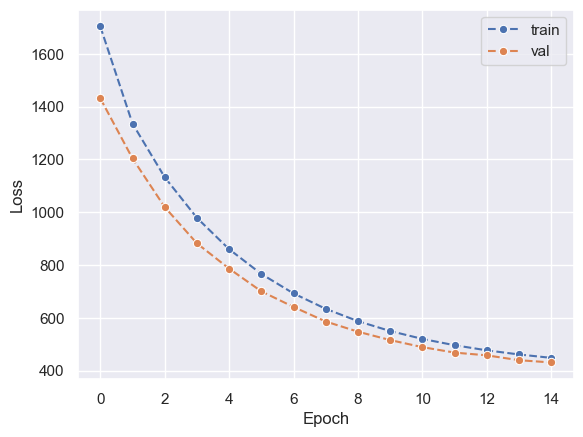

In [44]:
# TODO plot losses
plot_losses(train_losses, val_losses)

In [45]:
# TODO comment on the loss curve. Does it look as expected? Why/Why not?
# If not, what might be the reason.
# The loss curve looks as expected. The loss decreases with each epoch.
# The train loss is lower than the val loss, because the model is trained on the train data and not on the val data.

**TODO** Compare the pytorch resulting loss value and the resulting loss from practical 1? Are they the same? Why?

The loss here is a bit worse, but we can see from the curve that it hasn't converged completely yet. Thus we might expect a better loss. It will however be at best as good as the one we had before, because we computed a closed-form solution with a single maximum.